## Seminar and homework

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Архитектуры encoder-decoder предназначены для преобразования чего угодно во что угодно, включая
 * Системы машинного перевода
 * [Генерация описания к изображению](http://mscoco.org/dataset/#captions-challenge2015) и [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Генерация [изображений по описанию](https://arxiv.org/abs/1511.02793) (рекуррентный кодер, конволюционный декодер)


## Наша задача: машинный перевод

Мы собираемся опробовать наши модели кодировщика-декодировщика на задаче машинного перевода с русского на английский. В частности, мы будем переводить описания отелей и хостелов. Эта задача демонстрирует масштабность машинного перевода и при этом не требует недельного обучения модели, если не использовать GPU.

Прежде чем мы перейдем к архитектуре, необходимо выполнить некоторую предварительную обработку. ~~Go tokenize~~ Хорошо, на этот раз мы выполнили предварительную обработку за вас. Как обычно, данные будут токенизированы с помощью WordPunctTokenizer.

Однако есть еще одна вещь, которую нужно сделать. Наши строки данных содержат уникальные редкие слова. Если мы будем оперировать на уровне слов, нам придется иметь дело с большим объемом словарного запаса. Если же мы будем использовать модели на уровне символов, то обработка последовательности займет много итераций. В этот раз мы выберем что-то среднее.

Один из популярных подходов называется [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt), он же __BPE__, а еще лучше BBPE. Алгоритм начинает с токенизации на уровне символов, а затем итеративно объединяет наиболее частые пары в течение N итераций. В результате частые слова объединяются в одну лексему, а редкие слова разбиваются на слоги или даже символы.


In [10]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: D:\Python\python.exe -m pip install --upgrade pip
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
--2025-03-24 16:30:43--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-24 16:30:44--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc6aa6eb65b2465a5bb0d114254.dl.dropboxusercontent.com/cd/0/inline/CmfIyA6OzrClZrgSuHG59FHm7HiUtrMxX10aG6_4tNU9cxOiAS4Kihft2nflTUC3MlIwNOZ0YhOSsFEI4JKXYEm4s_6FJJSaKSesESijH2w_C2PmQhca7DPM5wBOk9JSKcU

In [11]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/d_dZfYoS4o4ckQ'
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)

In [12]:
with open('./vocab.py', 'wb') as f:
    f.write(download_response.content)

In [13]:
import chardet

with open('data.txt', 'rb') as f:
    rawdata = f.read()
    result = chardet.detect(rawdata)
    print(result)

{'encoding': 'MacRoman', 'confidence': 0.7063629999817905, 'language': ''}


In [22]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:04<00:00, 1617.51it/s]


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [25]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [26]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2601, 2856, 1125,   29,    1,    1,    1],
        [   0, 2835, 1749, 7947,   59, 3713,   29,    1],
        [   0, 5943, 1998,   29,    1,    1,    1,    1],
        [   0, 4840, 1785,   29,    1,    1,    1,    1],
        [   0, 5462, 1467,   27,  599,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

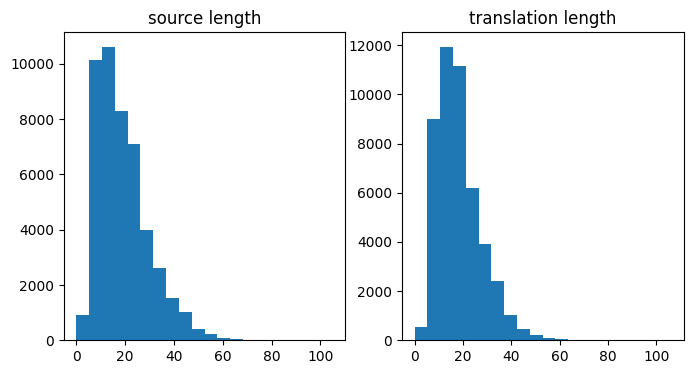

In [27]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

Код ниже содержит шаблон для простой модели кодера-декодера: один GRU-кодер/декодер, никакого внимания или чего-либо еще. Чистый BASELINE.

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]

        emb = self.emb_out(prev_tokens)
        new_gru0_state = self.dec0(emb, prev_gru0_state)
        output_logits = self.logits(new_gru0_state)

        return [new_gru0_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [31]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [32]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
cottages lakes guest vicinity vicinity tyr@@ excursions eca ysk bodrum kro@@ post friedrich@@ multilingual multilingual me@@ por@@ mes@@ yuan trac@@ app@@ n base@@ gir gir
cottages lakes guest vicinity vicinity tyr@@ excursions eca ysk bodrum kro@@ post friedrich@@ multilingual multilingual me@@ por@@ mes@@ yuan trac@@ app@@ n base@@ gir gir
cottages lakes guest vicinity vicinity tyr@@ excursions eca ysk bodrum kro@@ post friedrich@@ multilingual multilingual me@@ por@@ mes@@ yuan trac@@ app@@ n base@@ gir gir


### Compute loss

Наша цель обучения почти такая же, как и для LM:

$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ - _общая длина всех последовательностей__, включая BOS и первый EOS, но исключая PAD.

In [33]:

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = F.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    loss = - (logp_out * mask).sum() / mask.sum()

    # average cross-entropy over tokens where mask == True
    return loss # average loss, scalar

In [34]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5689, device='cuda:0', grad_fn=<DivBackward0>)


### Оценка: BLEU

Машинный перевод обычно оценивается с помощью оценки [BLEU](https://en.wikipedia.org/wiki/BLEU). Эта метрика просто вычисляет, какая доля предсказанных n-грамм действительно присутствует в эталонном переводе. Она делает это для n=1,2,3 и 4 и вычисляет среднее геометрическое со штрафом, если перевод короче эталонного.

Хотя у BLEU [есть много недостатков] (http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), она по-прежнему остается наиболее часто используемой метрикой и одной из самых простых в вычислении.

In [35]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [36]:
compute_bleu(model, dev_inp, dev_out)

0.0023800376174423704

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [37]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

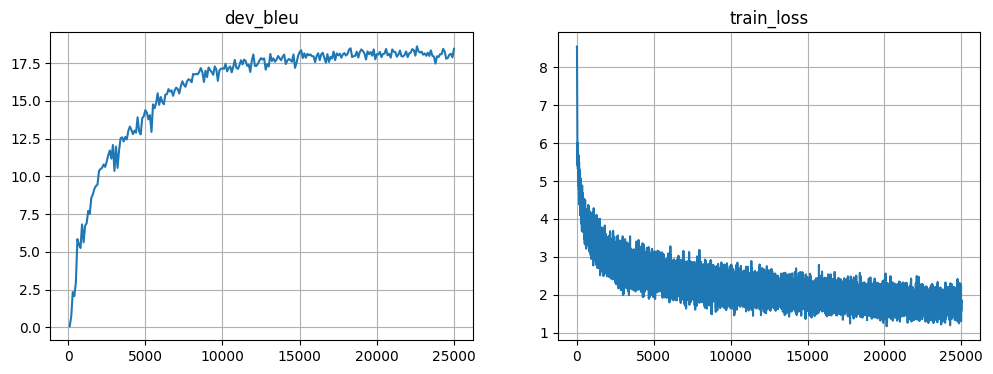

Mean loss=1.741


100%|██████████| 25000/25000 [10:35<00:00, 39.35it/s]


In [38]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    #<YOUR CODE: training step using batch_inp and batch_out>
    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [39]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [40]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen at the property .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
car parking is available and free parking and car rental services are available .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the city of zadar is 26 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
situated in a 5 - minute walk , this apartment features a garden and a seating area , a seating area and a garden .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in the centre of moscow , this apartment is a 1 - bedroom apartment with a hot tub , a hot tub and a hot tub .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower

### Требуется Ваше Внимание xD

В этом разделе мы хотим, чтобы вы улучшили базовую модель, реализовав простой механизм внимания.

Это будет две задачи: создание  слоя __attention__ и его использование для  модели __attention seq2seq__.

### Attention layer

Здесь вам предстоит реализовать слой, который вычисляет simple addition attention:
Дана последовательность енкодеров $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и одно состояние декодера $h^d$,
* Вычислите логиты с помощью двухслойной нейронной сети
$$a_t= linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получение "вероятностей" из логитов,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$
* Сложите состояния кодировщика с вероятностями, чтобы получить __attention response__.
$$ attn = \sum_t p_t \cdot h^e_t $$

In [41]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        # create trainable paramteres like this:
        #self.<PARAMETER_NAME> = nn.Parameter(<INITIAL_VALUES>, requires_grad=True)
        #<...>  # you will need a couple of these
        self.linear_e = nn.Linear(enc_size, hid_size, bias=False)
        self.linear_d = nn.Linear(dec_size, hid_size, bias=True)
        self.linear_out = nn.Linear(hid_size, 1, bias=False)


    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        enc_proj = self.linear_e(enc)
        dec_proj = self.linear_d(dec).unsqueeze(1)

        # Compute logits
        attn_hidden = self.activ(enc_proj + dec_proj)
        logits = self.linear_out(attn_hidden).squeeze(-1)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        logits_masked = torch.where(
            inp_mask > 0,
            logits,
            torch.tensor(-1e9, device=logits.device)
        )

        # Compute attention probabilities (softmax)
        probs = F.softmax(logits_masked, dim=1)

        # Compute attention response using enc and probs
        attn = torch.sum(enc * probs.unsqueeze(-1), dim=1)

        return attn, probs

### Seq2seq model with attention (3 points)

Теперь вы можете использовать слой внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодера:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

На каждом шаге используйте состояние _?_предыдущего__ декодера для рассчета attention. затем конкатим и передаем далее на вход.

Ключевой деталью реализации здесь является __model state__. Проще говоря, вы можете добавить любой тензор в список выходов `encode`. Затем вы будете иметь к ним доступ на каждом шаге `декодирования`. К ним могут относиться:
* Последние скрытые состояния RNN (как в базовой модели)
* Всю последовательность выходов кодuировщика (на которые нужно обратить внимание) и маску
* Вероятности внимания (для визуализацhbии)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        <YOUR CODE: initialize layers>

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """

        # encode input sequence, create initial decoder states
        <YOUR CODE>

        # apply attention layer from initial decoder hidden state
        first_attn_probas = <...>

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [<...>, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        <YOUR CODE HERE>
        return [new_dec_state, output_logits]


### Training attentive model

просто архитектура обычной модели, избегайте сложностей))

In [ ]:
<YOUR CODE: create AttentiveModel and training utilities>

In [ ]:
<YOUR CODE: training loop>

In [ ]:
<YOUR CODE: measure final BLEU>

### Визуализация внимания модели (2 балла)
После обучения модели внимательного перевода вы можете проверить ее работоспособность, визуализировав веса внимания.

Попробуй проинтепретировать их


In [ ]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

In [ ]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)
attention_probs = <YOUR CODE>

In [ ]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])

# Does it look fine already? don't forget to save images for anytask!

## Goind deeper (2++ балла)

А теперь реши эту задачу с учетом всего, что ты знаешь:

1) различные lstm / rnn / gru

2) bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)

3) word dropout, training schedules, layernorm / batchnorm

4) долой greedy decoding, делаем beam-search!

`Напиши добротный, подробный отчет о своих результатах`